In [1]:
!nvidia-smi  --query-gpu=name,memory.total,memory.used --format=csv,noheader

NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188 MiB, 107 MiB


Coded by B.Heddle, E. Porter and N. Wong

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import umap
from torchvision.ops import nms

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

Label_encoder = LabelEncoder()

C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the train data_trainset
data_train = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)

#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_train['gender'] = data_train['gender'].map(gender_conversion)

data_train['name'] = data_train['first'] + " " + data_train['last']
data_train['address'] = data_train['street'] + ", " + data_train['city'] + ", " + data_train['state']

#Convert first name
data_train['first#'] = Label_encoder.fit_transform(data_train['first'])

#Convert last  name
data_train['last#'] = Label_encoder.fit_transform(data_train['last'])

#Convert first name + last name
data_train['name#'] = Label_encoder.fit_transform(data_train['name'])

#data_train['age'] = 2024 - pd.to_numeric(data_train['dob'].str[:4]) 

#Convert Job
data_train['job#'] = Label_encoder.fit_transform(data_train['job'])

data_train['merchant#'] = Label_encoder.fit_transform(data_train['merchant'])

data_train['category#'] = Label_encoder.fit_transform(data_train['category'])


data_train['street#'] = Label_encoder.fit_transform(data_train['street'])
data_train['city#'] = Label_encoder.fit_transform(data_train['city'])
data_train['state#'] = Label_encoder.fit_transform(data_train['state'])

data_train['address#'] = Label_encoder.fit_transform(data_train['address'])

data_train['trans_num'] = Label_encoder.fit_transform(data_train['trans_num'])

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column to create a new 'age' column
data_train['age'] = data_train['dob'].apply(calculate_age)

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Calculate distance for each row
data_train['distance_km'] = haversine(data_train['lat'], data_train['long'], data_train['merch_lat'], data_train['merch_long'])


#data_train = data_train.drop(columns=['first', 'last', 'street', 'street', 'city', 'state', 'trans_date_trans_time', 'Unnamed: 0', 'dob'])
data_train = data_train.drop(columns=['trans_date_trans_time','Unnamed: 0', 'dob'])# 'Unnamed: 0'])



data_train.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,name,address,first#,last#,name#,job#,merchant#,category#,street#,city#,state#,address#,age,distance_km
0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,98699,1371816865,33.986391,-81.200714,0,Jeff Elliott,"351 Darlene Green, Columbia, SC",151,115,377,275,319,10,341,157,39,341,56,24.561462
1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",108785,1371816873,39.450498,-109.960431,0,Joanne Williams,"3638 Marsh Union, Altonah, UT",163,457,428,392,591,10,354,16,43,354,34,104.925092
2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,0,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",433979,1371816893,40.495810,-74.196111,0,Ashley Lopez,"9333 Valentine Point, Bellmore, NY",24,249,70,259,611,5,865,61,33,865,54,59.080078
3,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,1,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,71993,1371816915,28.812398,-80.883061,0,Brian Williams,"32941 Krystal Mill Apt. 552, Titusville, FL",42,457,109,407,222,9,320,764,8,320,37,27.698567
4,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,1,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,190585,1371816917,44.959148,-85.884734,0,Nathan Massey,"5783 Evan Roads Apt. 465, Falmouth, MI",247,261,678,196,292,13,548,247,21,548,69,104.335106


In [4]:
# Load the test dataset
data_test = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)


#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_test['gender'] = data_test['gender'].map(gender_conversion)

data_test['name'] = data_test['first'] + " " + data_test['last']
data_test['address'] = data_test['street'] + ", " + data_test['city'] + ", " + data_test['state']

#Convert first name
data_test['first#'] = Label_encoder.fit_transform(data_test['first'])

#Convert last  name
data_test['last#'] = Label_encoder.fit_transform(data_test['last'])

#Convert first name + last name
data_test['name#'] = Label_encoder.fit_transform(data_test['name'])

#data_test['age'] = 2024 - pd.to_numeric(data_test['dob'].str[:4]) 

#Convert Job
data_test['job#'] = Label_encoder.fit_transform(data_test['job'])

data_test['merchant#'] = Label_encoder.fit_transform(data_test['merchant'])

data_test['category#'] = Label_encoder.fit_transform(data_test['category'])


data_test['street#'] = Label_encoder.fit_transform(data_test['street'])
data_test['city#'] = Label_encoder.fit_transform(data_test['city'])
data_test['state#'] = Label_encoder.fit_transform(data_test['state'])

data_test['address#'] = Label_encoder.fit_transform(data_test['address'])

data_test['trans_num'] = Label_encoder.fit_transform(data_test['trans_num'])

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column to create a new 'age' column
data_test['age'] = data_test['dob'].apply(calculate_age)

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Calculate distance for each row
data_test['distance_km'] = haversine(data_test['lat'], data_test['long'], data_test['merch_lat'], data_test['merch_long'])


#data_test = data_test.drop(columns=['first', 'last', 'street', 'street', 'city', 'state', 'trans_date_trans_time', 'Unnamed: 0', 'dob'])
data_test = data_test.drop(columns=['trans_date_trans_time','Unnamed: 0', 'dob'])# 'Unnamed: 0'])



data_test.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,name,address,first#,last#,name#,job#,merchant#,category#,street#,city#,state#,address#,age,distance_km
0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,98699,1371816865,33.986391,-81.200714,0,Jeff Elliott,"351 Darlene Green, Columbia, SC",151,115,377,275,319,10,341,157,39,341,56,24.561462
1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",108785,1371816873,39.450498,-109.960431,0,Joanne Williams,"3638 Marsh Union, Altonah, UT",163,457,428,392,591,10,354,16,43,354,34,104.925092
2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,0,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",433979,1371816893,40.495810,-74.196111,0,Ashley Lopez,"9333 Valentine Point, Bellmore, NY",24,249,70,259,611,5,865,61,33,865,54,59.080078
3,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,1,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,71993,1371816915,28.812398,-80.883061,0,Brian Williams,"32941 Krystal Mill Apt. 552, Titusville, FL",42,457,109,407,222,9,320,764,8,320,37,27.698567
4,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,1,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,190585,1371816917,44.959148,-85.884734,0,Nathan Massey,"5783 Evan Roads Apt. 465, Falmouth, MI",247,261,678,196,292,13,548,247,21,548,69,104.335106


In [5]:
X_train = data_train.drop(columns=['is_fraud'], axis=1)
y_train = data_train['is_fraud']

X_test = data_test.drop(columns=['is_fraud'], axis=1)
y_test = data_test['is_fraud']

# Identify numerical and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('umap', umap.UMAP(n_components=5, random_state=42))  # UMAP for dimensionality reduction
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create AdaBoost model
estimator = DecisionTreeClassifier(max_depth=5) #Depth = 5, 100 weak learners
model = AdaBoostClassifier(estimator=estimator, n_estimators=100, random_state=20201107)





In [6]:
# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# If you want to visualize UMAP transformations on the training data
# First, transform the data using the preprocessor (including UMAP)
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)

# Convert sparse matrix to dense (as UMAP cannot handle sparse matrices directly)
X_train_transformed_dense = X_train_transformed.toarray()

# UMAP transformation is part of the numeric pipeline, so we access the UMAP component
umap_model = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['umap']
X_train_umap = umap_model.transform(X_train_transformed_dense)

C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


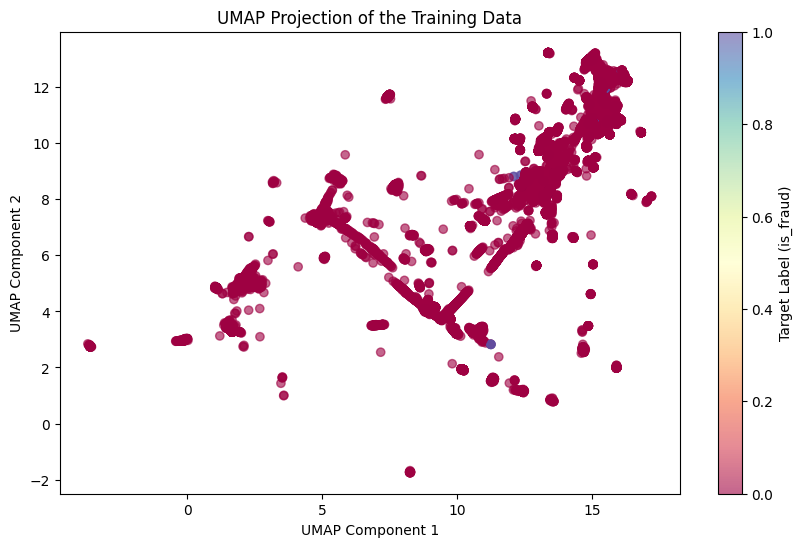

In [7]:

# Plot the UMAP transformation (2D plot)
plt.figure(figsize=(10, 6))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='Spectral', alpha=0.6)
plt.colorbar(label='Target Label (is_fraud)')
plt.title('UMAP Projection of the Training Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [8]:
# Predictions on the test data
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9997984592932759
AUC Score: 0.9999967462967893

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       1.00      0.95      0.97      2145

    accuracy                           1.00    555719
   macro avg       1.00      0.98      0.99    555719
weighted avg       1.00      1.00      1.00    555719



In [9]:
# Create AdaBoost model -> depth = 1, weak learners = 100
estimator = DecisionTreeClassifier(max_depth=1)
model = AdaBoostClassifier(estimator=estimator, n_estimators=100, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.996737559809904
AUC Score: 0.9589378966127151

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.99      0.16      0.27      2145

    accuracy                           1.00    555719
   macro avg       1.00      0.58      0.63    555719
weighted avg       1.00      1.00      1.00    555719



In [11]:
# Create AdaBoost model -> depth = 2, weak learners = 100
estimator = DecisionTreeClassifier(max_depth=2)
model = AdaBoostClassifier(estimator=estimator, n_estimators=100, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9984398589934841
AUC Score: 0.990169980664657

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.95      0.63      0.76      2145

    accuracy                           1.00    555719
   macro avg       0.98      0.81      0.88    555719
weighted avg       1.00      1.00      1.00    555719



In [12]:
# Create AdaBoost model -> depth = 2, weak learners = 200
estimator = DecisionTreeClassifier(max_depth=2)
model = AdaBoostClassifier(estimator=estimator, n_estimators=200, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9986413997002082
AUC Score: 0.996607060861885

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.97      0.67      0.79      2145

    accuracy                           1.00    555719
   macro avg       0.98      0.84      0.90    555719
weighted avg       1.00      1.00      1.00    555719



In [13]:
# Create AdaBoost model
estimator = DecisionTreeClassifier(max_depth=3)
model = AdaBoostClassifier(estimator=estimator, n_estimators=200, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9992532197027635
AUC Score: 0.9998169715096449

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.99      0.82      0.89      2145

    accuracy                           1.00    555719
   macro avg       0.99      0.91      0.95    555719
weighted avg       1.00      1.00      1.00    555719



In [15]:
# Create AdaBoost model
estimator = DecisionTreeClassifier(max_depth=2)
model = AdaBoostClassifier(estimator=estimator, n_estimators=300, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9988573361716983
AUC Score: 0.9989488273206439

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.97      0.72      0.83      2145

    accuracy                           1.00    555719
   macro avg       0.99      0.86      0.91    555719
weighted avg       1.00      1.00      1.00    555719



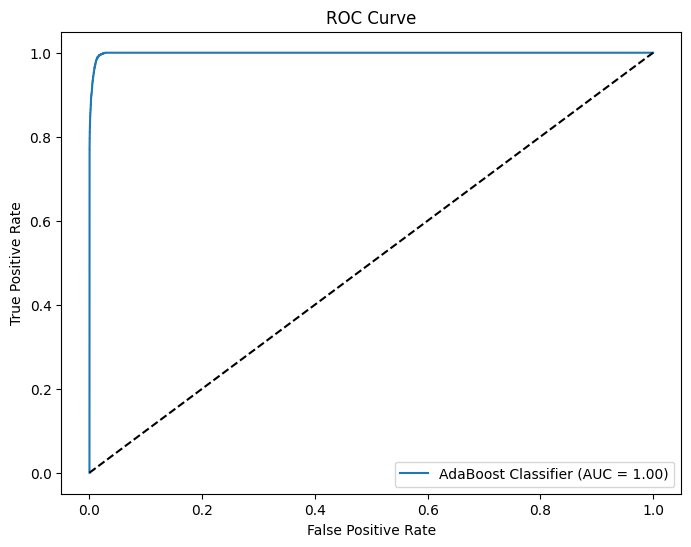

In [16]:

# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AdaBoost Classifier (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

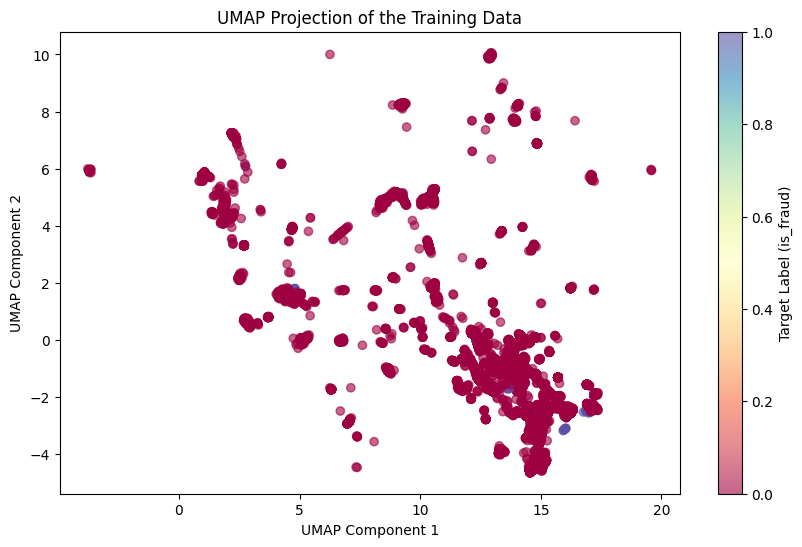

In [18]:
# Get the preprocessor and AdaBoost model
preprocessor = pipeline.named_steps['preprocessor']
adaboost_model = pipeline.named_steps['classifier']

# Get the UMAP transformation (instead of PCA)
umap_model = preprocessor.named_transformers_['num'].named_steps['umap']

# Transform the data using the preprocessor
X_train_transformed = preprocessor.transform(X_train)

# Convert sparse matrix to dense NumPy array before applying UMAP
X_train_dense = X_train_transformed.toarray()

# Transform the data using the UMAP model
X_train_umap = umap_model.transform(X_train_dense)

# Plot the UMAP transformation (2D plot)
plt.figure(figsize=(10, 6))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='Spectral', alpha=0.6)
plt.colorbar(label='Target Label (is_fraud)')
plt.title('UMAP Projection of the Training Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()


UMAP components shape: (555719, 5)
UMAP feature names length: 5
One-hot encoded feature names length: 5661
Mismatch in lengths between UMAP components and one-hot encoded features.
Feature 'merchant_fraud_Abbott-Rogahn' not found in X_train.
Feature 'merchant_fraud_Abbott-Steuber' not found in X_train.
Feature 'merchant_fraud_Abernathy and Sons' not found in X_train.
Feature 'merchant_fraud_Abshire PLC' not found in X_train.
Feature 'merchant_fraud_Adams, Kovacek and Kuhlman' not found in X_train.
Feature 'merchant_fraud_Adams-Barrows' not found in X_train.
Feature 'merchant_fraud_Altenwerth, Cartwright and Koss' not found in X_train.
Feature 'merchant_fraud_Altenwerth-Kilback' not found in X_train.
Feature 'merchant_fraud_Ankunding LLC' not found in X_train.
Feature 'merchant_fraud_Ankunding-Carroll' not found in X_train.
Feature 'merchant_fraud_Armstrong, Walter and Gottlieb' not found in X_train.
Feature 'merchant_fraud_Auer LLC' not found in X_train.
Feature 'merchant_fraud_Auer-Mo

C:\Users\eporter3\AppData\Local\Temp\ipykernel_55764\3117496018.py:55: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


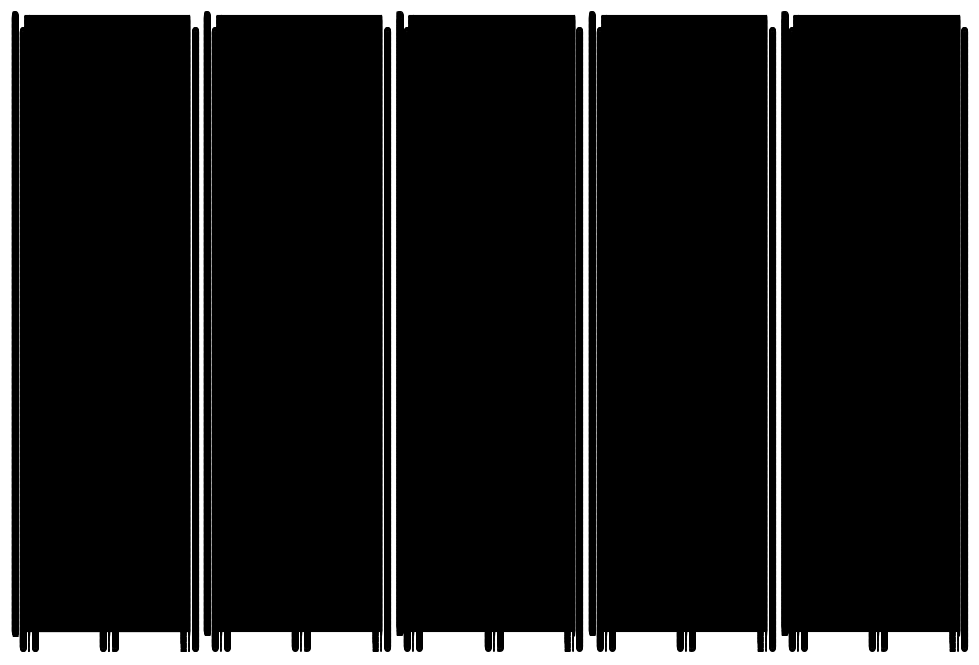

In [22]:
# Extract one-hot encoded feature names for categorical features
cat_onehot_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Create UMAP feature names
umap_feature_names = [f"UMAP_Component_{i+1}" for i in range(X_train_umap.shape[1])]

# Create the UMAP DataFrame
umap_df = pd.DataFrame(X_train_umap, columns=umap_feature_names)

# Check that the number of UMAP components matches with the number of columns in `X_train_umap`
print(f"UMAP components shape: {X_train_umap.shape}")
print(f"UMAP feature names length: {len(umap_feature_names)}")
print(f"One-hot encoded feature names length: {len(cat_onehot_names)}")

# If you are only interested in UMAP components and the one-hot features, 
# you can create a separate DataFrame like this:

# Combine the categorical one-hot names with the UMAP components
# The following is just a column-wise combination for display
# Ensure all arrays have the same length
if len(cat_onehot_names) + len(umap_feature_names) == X_train_umap.shape[1]:
    all_feature_names = umap_feature_names + cat_onehot_names.tolist()

    # Create the DataFrame with the combined names and UMAP components
    feature_importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'UMAP Component 1': X_train_umap[:, 0],
        'UMAP Component 2': X_train_umap[:, 1]
    })

    # Display the UMAP feature mapping for visual inspection
    print(feature_importance_df.head())
else:
    print("Mismatch in lengths between UMAP components and one-hot encoded features.")

# Calculate number of rows and columns based on the number of features
n_features = len(cat_onehot_names)
n_cols = 5  # You can adjust the number of columns
n_rows = (n_features // n_cols) + (n_features % n_cols > 0)  # Ensure we have enough rows

# Create a larger figure with an appropriate number of subplots
plt.figure(figsize=(12, 8))
for i, feature in enumerate(cat_onehot_names):
    plt.subplot(n_rows, n_cols, i+1)  # Adjust the grid based on the number of features

    # Check if the feature exists in the original DataFrame (X_train)
    if feature in X_train.columns:
        plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=X_train[feature], cmap='Spectral', alpha=0.6)
        plt.title(feature)
    else:
        # If the feature doesn't exist in X_train, print a message and skip plotting
        print(f"Feature '{feature}' not found in X_train.")
        continue

plt.tight_layout()
plt.show()